### 0. Load Dependencies

In [1]:
import numpy as np
import pandas as pd
import pickle
import time
from KNN_Shapley import get_VN, get_true_KNN, compute_KNN_shapley, compute_KNN_Asymmetric_Shapley, KNN_LOO
from performance_plot import removing_sequential_data, adding_sequential_data, final_plot

### 1. Load Data

In [2]:
# Load data
n_samples = 10
num_classes, num_trn, num_val, num_heldout, n_augs = 20, 100, 100, 100, 1
shift_limit_dx, shift_limit_dy, scale_limit, rotate_limit = 0.0625, 0.0625, 0.1, 45
param_setting = "num_classes={}_num_trn={}_num_val={}_num_heldout={}_n_augs={}".format(num_classes, num_trn, num_val, num_heldout, n_augs)

X_ori_lst, y_ori_lst, X_aug_lst, y_aug_lst, X_ori_aug_lst, y_ori_aug_lst, X_val_lst, y_val_lst = [], [], [], [], [], [], [], []
X_heldout_lst, y_heldout_lst = [], []

for i_sample in range(n_samples):
    with open("data/omniglot/Augmented_sample{}_".format(i_sample+1) + param_setting + ".pickle", "rb") as fp:
        mydict = pickle.load(fp)

    X_ori_lst.append(mydict['X_ori'])
    y_ori_lst.append(mydict['y_ori'].astype('int64'))
    
    X_aug_lst.append(mydict['X_aug'])
    y_aug_lst.append(mydict['y_aug'].astype('int64'))
    
    X_ori_aug_lst.append(mydict['X_ori_aug'])
    y_ori_aug_lst.append(mydict['y_ori_aug'].astype('int64'))
    
    X_val_lst.append(mydict['X_val'])
    y_val_lst.append(mydict['y_val'].astype('int64'))
    
    X_heldout_lst.append(mydict['X_heldout'])
    y_heldout_lst.append(mydict['y_heldout'].astype('int64'))

s_class_dic = {0:np.asarray(range(len(X_ori_lst[0]))), 
               1:np.asarray(range(len(X_ori_lst[0]), len(X_ori_aug_lst[0])))}

In [3]:
X_ori_lst[0].shape, X_aug_lst[0].shape, X_ori_aug_lst[0].shape, X_val_lst[0].shape

((100, 784), (100, 784), (200, 784), (100, 784))

### 2. Compute KNN Shapley and Asymmetric Shapley

In [4]:
# K = 5

In [5]:
# for i_sample in range(n_samples):
    
#     print('i_sample', i_sample)
#     directory = 'experiments/omniglot/sample{}/'.format(i_sample+1)

#     # Train KNN Classifier
#     x_ori_aug_knn_gt = get_true_KNN(X_ori_aug_lst[i_sample], X_val_lst[i_sample])  # train knn classifier
    
#     # Compute KNN shapley
#     start = time.time()
#     knn_shaps = compute_KNN_shapley(y_ori_aug_lst[i_sample], x_ori_aug_knn_gt, y_val_lst[i_sample], K)
#     end = time.time()
#     print("Time to compute the exact symmetric shapley values for all data:", end - start)
#     np.save(directory + 'ori_aug_sv_K={}_'.format(K) + param_setting, knn_shaps)
    
#     # Compute KNN asymmetric shapley
#     start = time.time()
#     knn_asym_shaps = compute_KNN_Asymmetric_Shapley(y_ori_aug_lst[i_sample], x_ori_aug_knn_gt, 
#                                                     y_val_lst[i_sample], K, s_class_dic)
#     end = time.time()
#     print("Time to compute the exact asymmetric shapley values for all data:", end - start)
#     np.save(directory + 'ori_aug_asv_K={}_'.format(K) + param_setting, knn_asym_shaps)

### 3. Load SV, ASV and LOO values

In [20]:
mc_sv_lst, mc_asv_lst, loo_lst, rand_lst = [], [], [], []
seeds = [42, 123, 2020, 314, 2021, 111, 999, 777, 1010, 888]
num_permutations = 1000

for i_sample in range(n_samples):
    
    print(' ')
    print(' ')
    print('i_sample', i_sample+1)
    directory = 'experiments/omniglot/sample{}/'.format(i_sample+1)
    
#     # Load knn sv
#     knn_sv = np.load(directory + 'ori_aug_sv_K={}_'.format(K) + param_setting + '.npy')
#     knn_sv_lst.append(knn_sv)
#     print('knn_sv.shape', knn_sv.shape)
    
#     # Load knn asv
#     knn_asv = np.load(directory + 'ori_aug_asv_K={}_'.format(K) + param_setting + '.npy')
#     knn_asv_lst.append(knn_asv)
#     print('knn_asv.shape', knn_asv.shape)
    
    # Load loo values
    with open(directory + 'loo_model=logistic_metric=accuracy.pkl', 'rb') as fp:
        loo_dict = pickle.load(fp)
    loo_logistic = loo_dict['loo']
    loo_lst.append(loo_logistic)
    print('loo_logistic.shape', loo_logistic.shape)
    
    # Load mc-sv
    with open(directory + 'tmc_shapley_model=logistic_metric=accuracy.pkl', 'rb') as fp:
        mc_sv_dict = pickle.load(fp)
    mc_sv_logistic = np.mean(mc_sv_dict['marginals_tmc'][:num_permutations], axis=0)
    mc_sv_lst.append(mc_sv_logistic)
    print('mc_sv_knn.shape', mc_sv_dict['marginals_tmc'].shape,
          mc_sv_dict['marginals_tmc'][:num_permutations].shape)
    
    # Load mc-asv
    with open(directory + 'tmc_asymmetric_shapley_model=logistic_metric=accuracy.pkl', 'rb') as fp:
        mc_asv_dict = pickle.load(fp)
    mc_asv_logistic = np.mean(mc_asv_dict['marginals_tmc'][:num_permutations], axis=0)
    mc_asv_lst.append(mc_asv_logistic)
    print('mc_asv_knn.shape', mc_asv_dict['marginals_tmc'].shape,
          mc_asv_dict['marginals_tmc'][:num_permutations].shape)
        
    # random permutation of values (baseline)
    seed = seeds[i_sample-1]
    np.random.seed(seed)
    rand_lst.append(np.random.rand(len(X_ori_aug_lst[i_sample])))

 
 
i_sample 1
loo_logistic.shape (200,)
mc_sv_knn.shape (2000, 200) (1000, 200)
mc_asv_knn.shape (2500, 200) (1000, 200)
 
 
i_sample 2
loo_logistic.shape (200,)
mc_sv_knn.shape (2000, 200) (1000, 200)
mc_asv_knn.shape (2500, 200) (1000, 200)
 
 
i_sample 3
loo_logistic.shape (200,)
mc_sv_knn.shape (2000, 200) (1000, 200)
mc_asv_knn.shape (2500, 200) (1000, 200)
 
 
i_sample 4
loo_logistic.shape (200,)
mc_sv_knn.shape (2000, 200) (1000, 200)
mc_asv_knn.shape (2500, 200) (1000, 200)
 
 
i_sample 5
loo_logistic.shape (200,)
mc_sv_knn.shape (2000, 200) (1000, 200)
mc_asv_knn.shape (2500, 200) (1000, 200)
 
 
i_sample 6
loo_logistic.shape (200,)
mc_sv_knn.shape (2000, 200) (1000, 200)
mc_asv_knn.shape (2000, 200) (1000, 200)
 
 
i_sample 7
loo_logistic.shape (200,)
mc_sv_knn.shape (1900, 200) (1000, 200)
mc_asv_knn.shape (2000, 200) (1000, 200)
 
 
i_sample 8
loo_logistic.shape (200,)
mc_sv_knn.shape (2000, 200) (1000, 200)
mc_asv_knn.shape (1900, 200) (1000, 200)
 
 
i_sample 9
loo_logis

### 3. Performance plot (Logistic)

In [21]:
import matplotlib.pyplot as plt

def removing_sequential_data(shap_vals_lst, shap_vals_algo_lst, X_ori_aug, y_ori_aug, X_test, y_test,
                             num_trn_ori, ind_arr, directory, model, metrics, plot_every_percentage, 
                             low_value_first=True):

    frac_data_removed = []
    sort_val_idxs_lst = []
    ind_arr_lst = []

    num_trn = len(X_ori_aug)
    num_trn_aug = num_trn - num_trn_ori

    for j in range(len(shap_vals_lst)):
        if low_value_first:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[j]))
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[j])])
        else:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[j])[::-1])
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[j])[::-1]])

    acc_score_lst = [[] for _ in range(len(shap_vals_lst))]
    
    for i in range(0, num_trn_aug, round(num_trn_aug * plot_every_percentage)):
        frac_data_removed.append(round(i / num_trn_aug, 2) * 100)
        for j in range(len(shap_vals_lst)):
            selected_idxs_j = np.concatenate((sort_val_idxs_lst[j][ind_arr_lst[j] == 1], sort_val_idxs_lst[j][ind_arr_lst[j] == 0][i:]))
            model.fit(X_ori_aug[selected_idxs_j], y_ori_aug[selected_idxs_j])
            preds = model.predict(X_test)
            if metrics=='acc':
                acc = accuracy_score(y_test, preds)
            elif metrics=='auc':
                acc = roc_auc_score(y_test, preds)
            acc_score_lst[j].append(acc)

    data_dict = dict(zip(shap_vals_algo_lst, acc_score_lst))
    data_dict['frac_data_removed'] = frac_data_removed

    with open(directory, "wb") as fp:
        pickle.dump(data_dict, fp)

    for i in range(len(shap_vals_algo_lst)):
        plt.plot(data_dict['frac_data_removed'], data_dict[shap_vals_algo_lst[i]], label=shap_vals_algo_lst[i])
    plt.legend(loc='best')
    plt.show()
    return


def adding_sequential_data(shap_vals_lst, shap_vals_algo_lst, X_ori_aug, y_ori_aug, X_test, y_test,
                            num_trn_ori, ind_arr, directory, model, metrics, plot_every_percentage, 
                           low_value_first=True):

    frac_data_removed = []
    sort_val_idxs_lst = []
    ind_arr_lst = []

    num_trn = len(X_ori_aug)
    num_trn_aug = num_trn - num_trn_ori

    for i in range(len(shap_vals_lst)):
        if low_value_first:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[i]))
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[i])])
        else:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[i])[::-1])
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[i])[::-1]])

    acc_score_lst = [[] for _ in range(len(shap_vals_lst))]

    for i in range(0, num_trn_aug, round(num_trn_aug * plot_every_percentage)):
        frac_data_removed.append(round(i / num_trn_aug, 2) * 100)
        for j in range(len(shap_vals_lst)):
            selected_idxs_j = np.concatenate((sort_val_idxs_lst[j][ind_arr_lst[j] == 1], sort_val_idxs_lst[j][ind_arr_lst[j] == 0][:i]))
            model.fit(X_ori_aug[selected_idxs_j], y_ori_aug[selected_idxs_j])
            preds = model.predict(X_test)
            if metrics=='acc':
                acc = accuracy_score(y_test, preds)
            elif metrics=='auc':
                acc = roc_auc_score(y_test, preds)
            acc_score_lst[j].append(acc)

    data_dict = dict(zip(shap_vals_algo_lst, acc_score_lst))
    data_dict['frac_data_added'] = frac_data_removed

    with open(directory, "wb") as fp:
        pickle.dump(data_dict, fp)

    for i in range(len(shap_vals_algo_lst)):
        plt.plot(data_dict['frac_data_added'], data_dict[shap_vals_algo_lst[i]], label=shap_vals_algo_lst[i])
    plt.legend(loc='best')
    plt.show()
    return

i_sample 0
Removing low value augmented data experiment started...


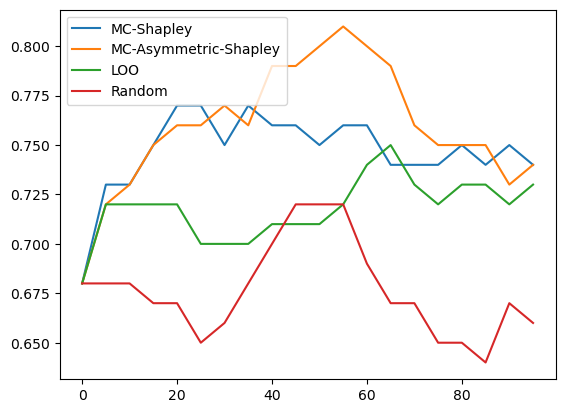

Removing high value augmented data experiment started...


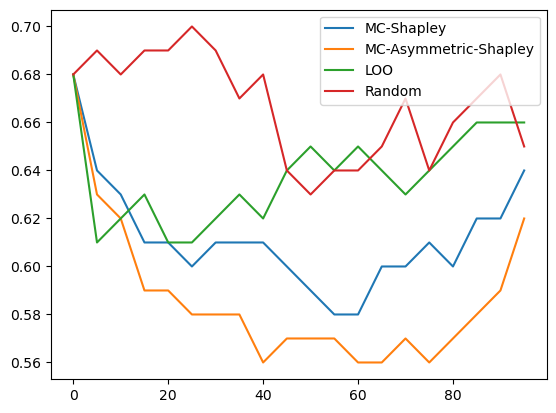

Adding low value augmented data experiment started...


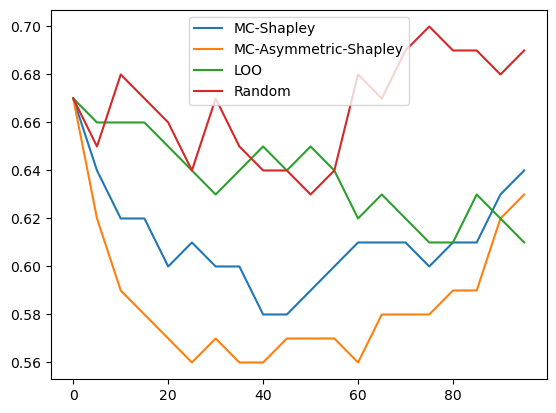

Adding high value augmented data experiment started...


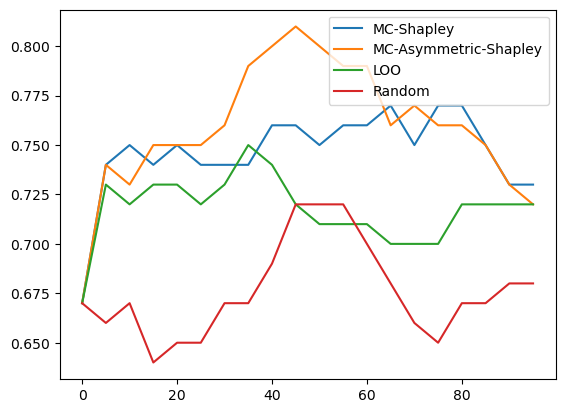

i_sample 1
Removing low value augmented data experiment started...


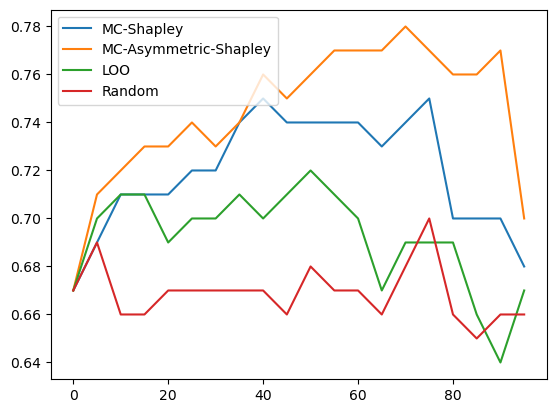

Removing high value augmented data experiment started...


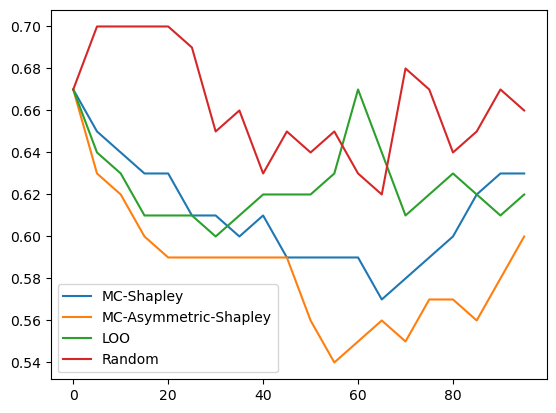

Adding low value augmented data experiment started...


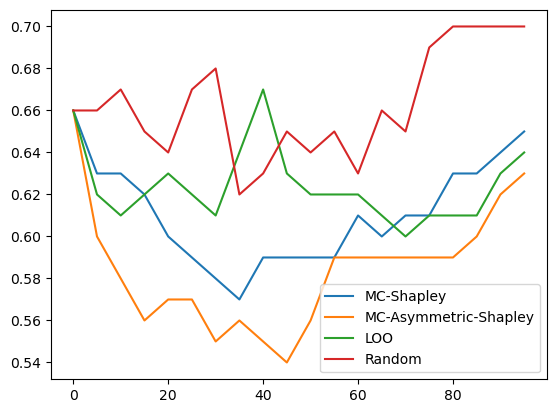

Adding high value augmented data experiment started...


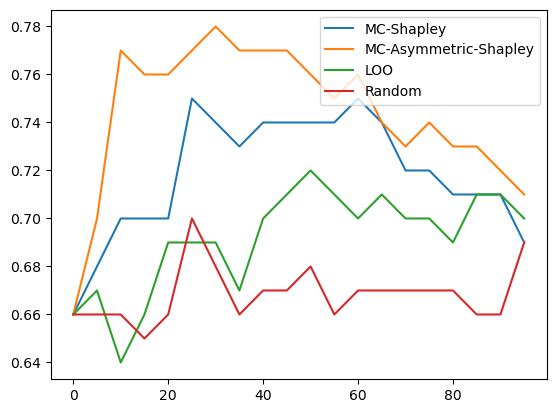

i_sample 2
Removing low value augmented data experiment started...


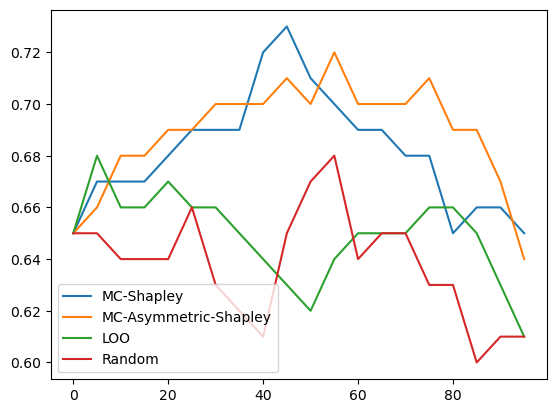

Removing high value augmented data experiment started...


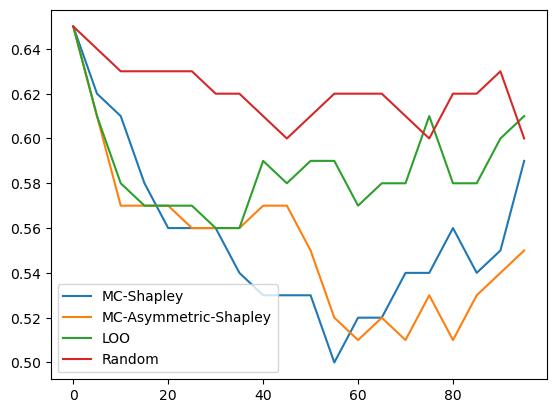

Adding low value augmented data experiment started...


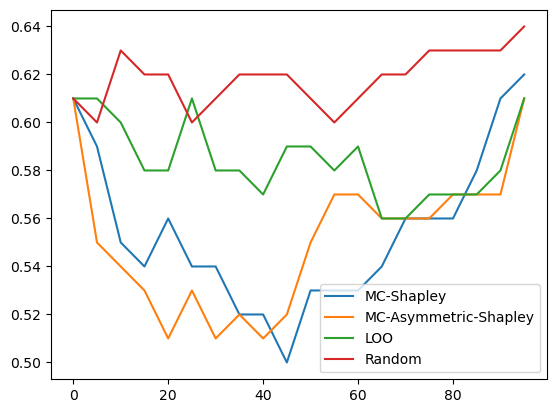

Adding high value augmented data experiment started...


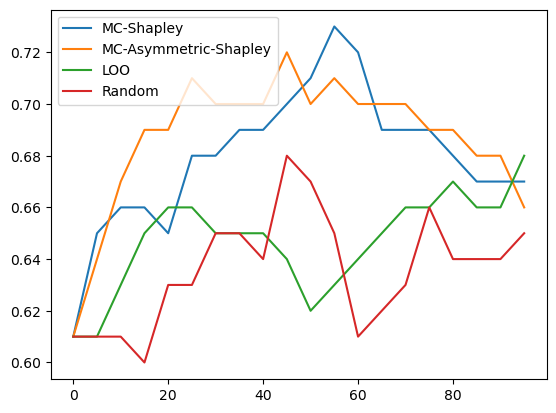

i_sample 3
Removing low value augmented data experiment started...


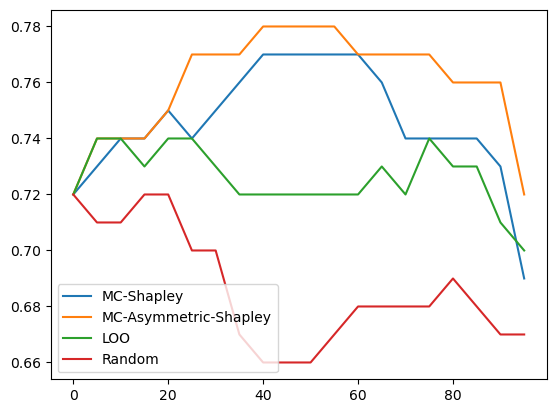

Removing high value augmented data experiment started...


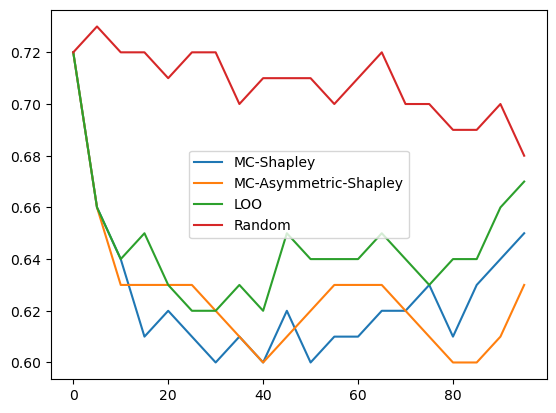

Adding low value augmented data experiment started...


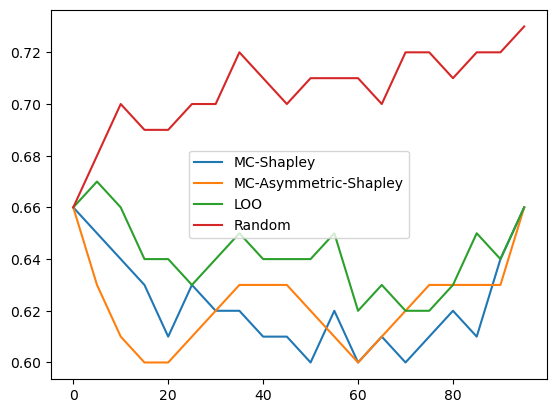

Adding high value augmented data experiment started...


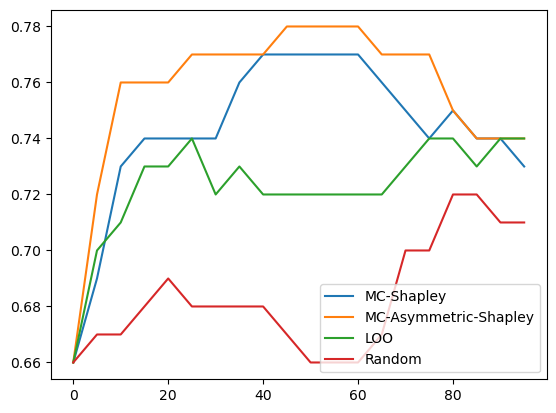

i_sample 4
Removing low value augmented data experiment started...


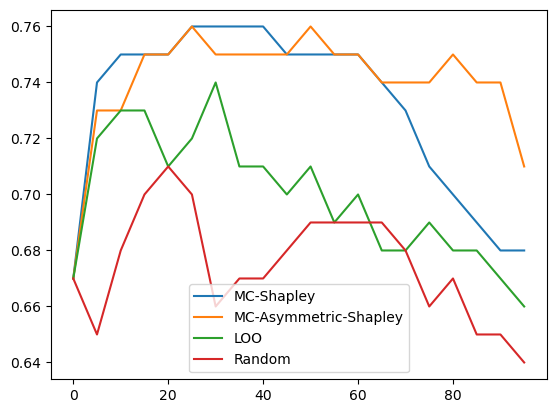

Removing high value augmented data experiment started...


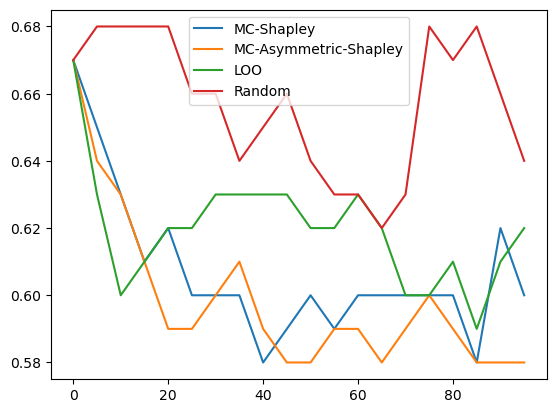

Adding low value augmented data experiment started...


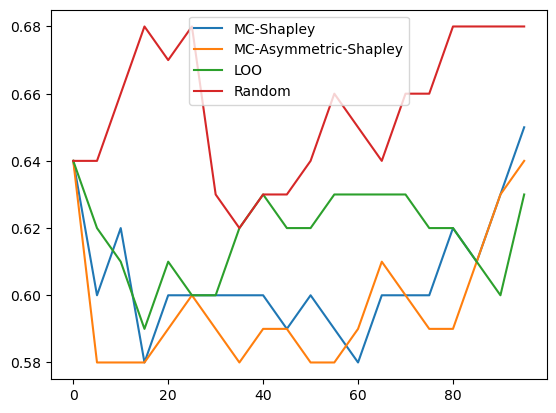

Adding high value augmented data experiment started...


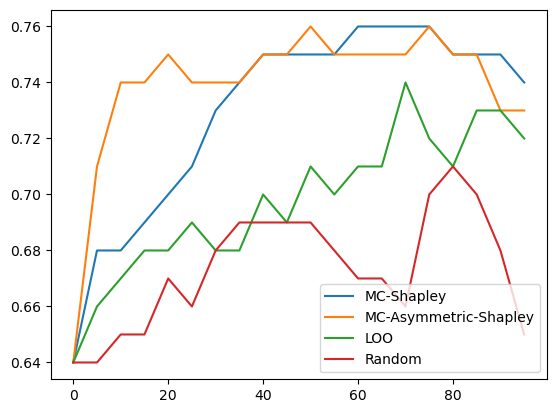

i_sample 5
Removing low value augmented data experiment started...


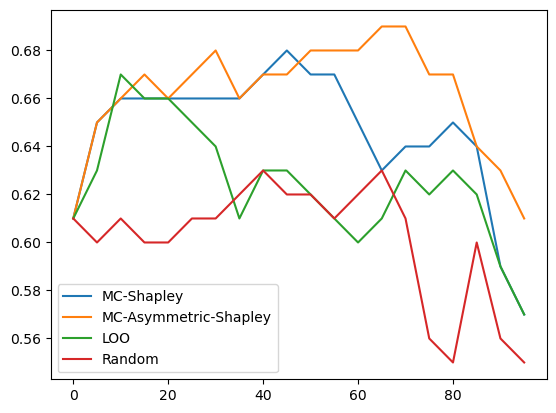

Removing high value augmented data experiment started...


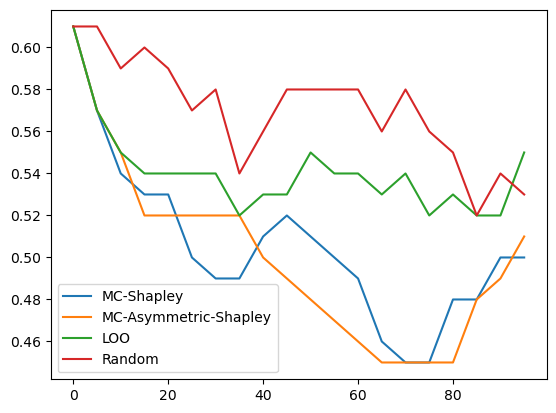

Adding low value augmented data experiment started...


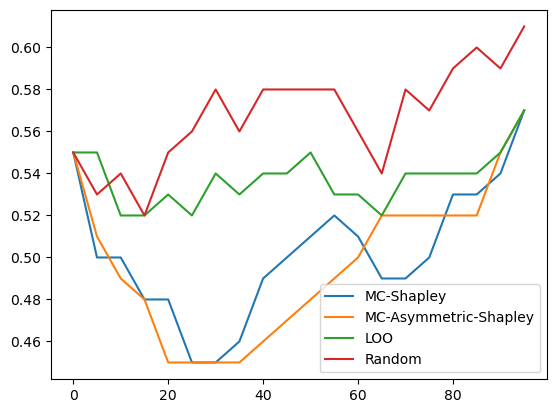

Adding high value augmented data experiment started...


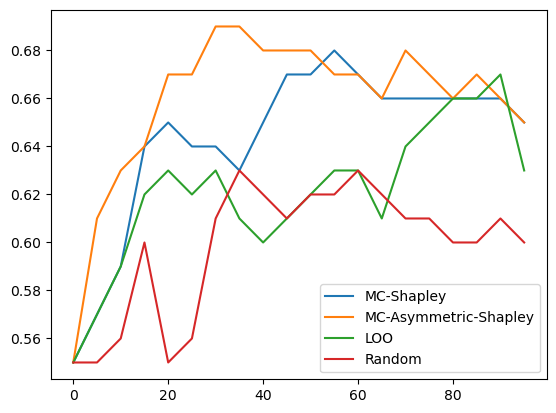

i_sample 6
Removing low value augmented data experiment started...


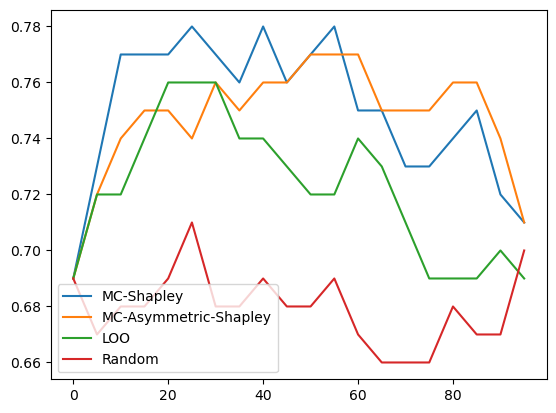

Removing high value augmented data experiment started...


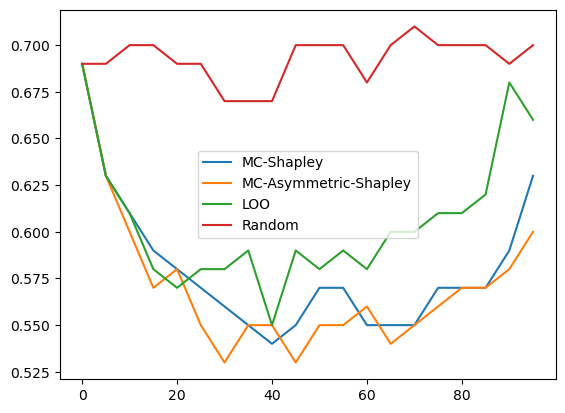

Adding low value augmented data experiment started...


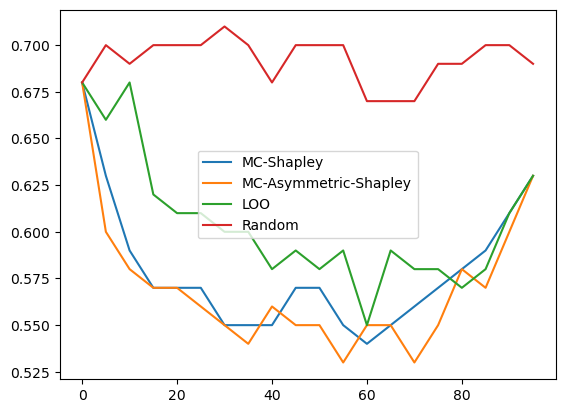

Adding high value augmented data experiment started...


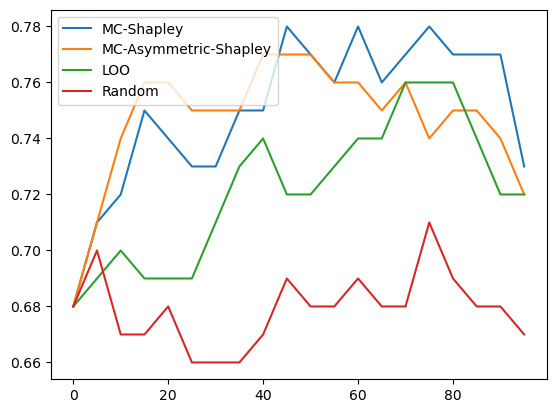

i_sample 7
Removing low value augmented data experiment started...


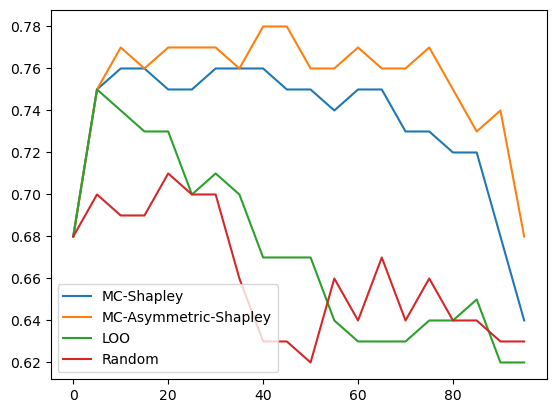

Removing high value augmented data experiment started...


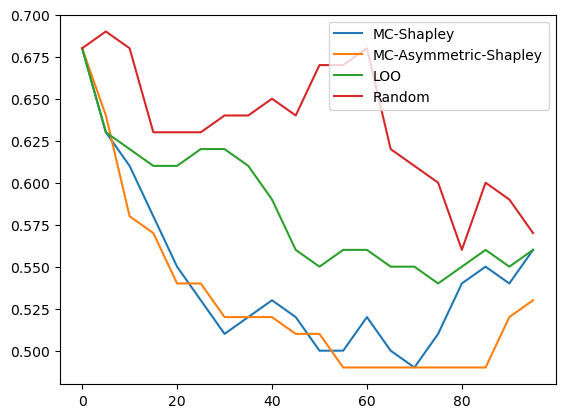

Adding low value augmented data experiment started...


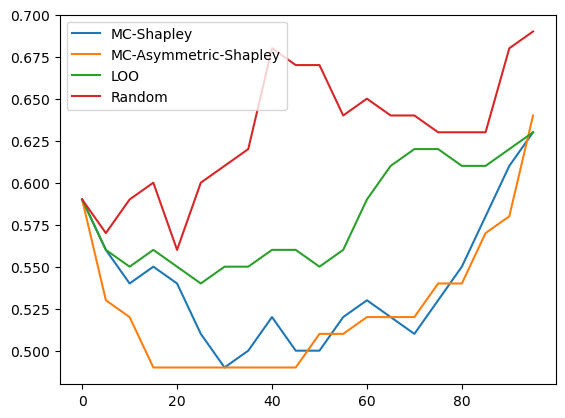

Adding high value augmented data experiment started...


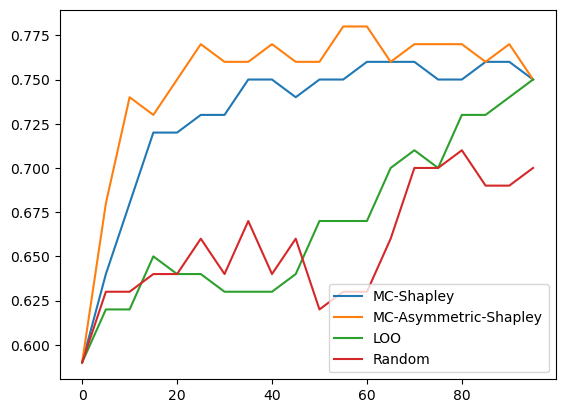

i_sample 8
Removing low value augmented data experiment started...


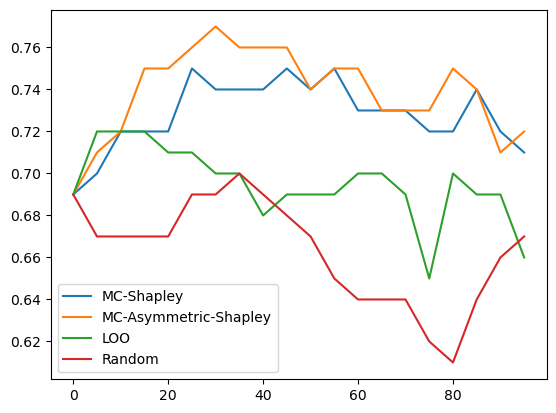

Removing high value augmented data experiment started...


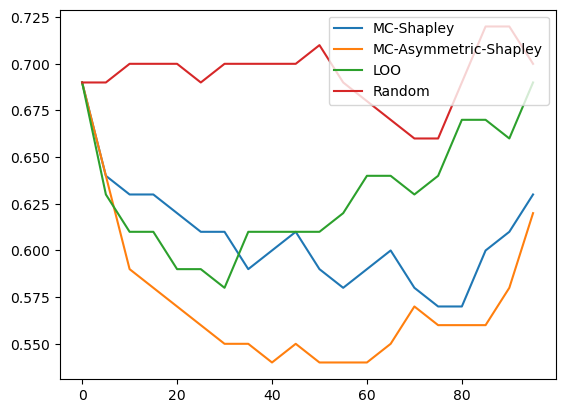

Adding low value augmented data experiment started...


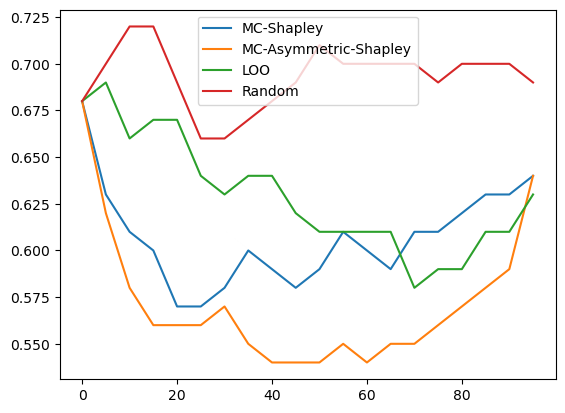

Adding high value augmented data experiment started...


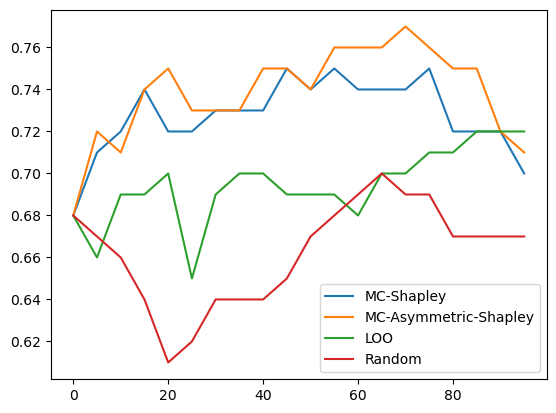

i_sample 9
Removing low value augmented data experiment started...


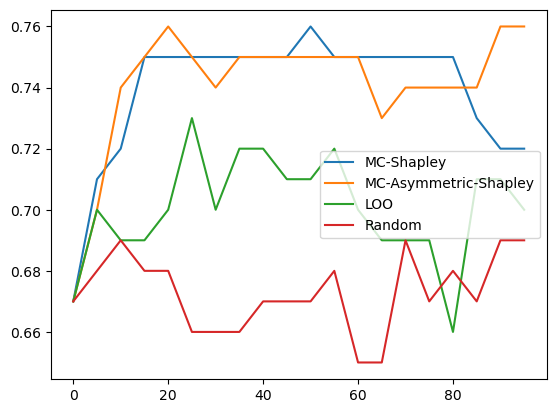

Removing high value augmented data experiment started...


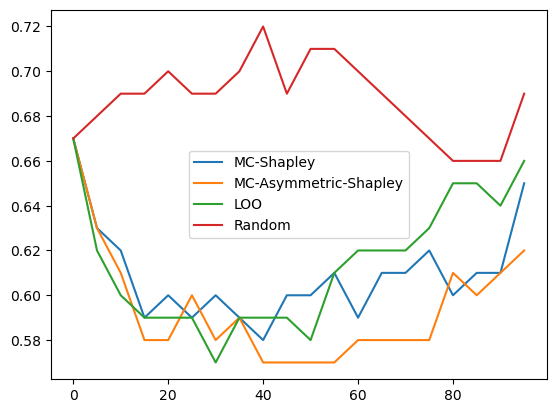

Adding low value augmented data experiment started...


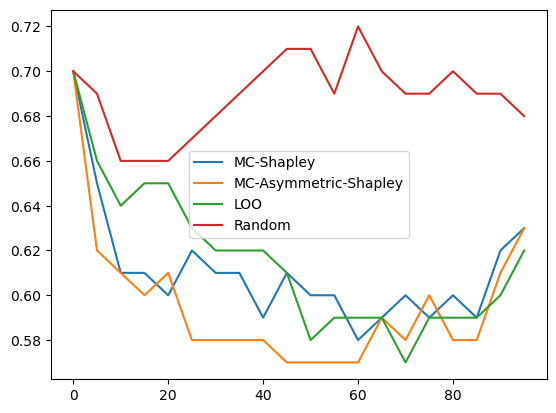

Adding high value augmented data experiment started...


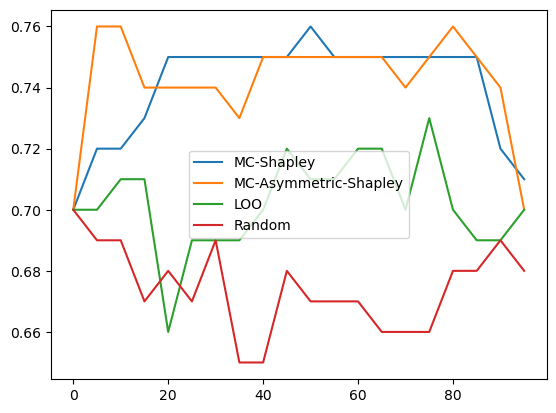

In [22]:
# Performance plot: validation data

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver='liblinear', max_iter=5000, random_state=666)
modelname = 'logistic'

for i_sample in range(n_samples):
    
    print('i_sample', i_sample)
    directory = 'experiments/omniglot/sample{}/'.format(i_sample+1)
    
    shap_vals_lst = [mc_sv_lst[i_sample], mc_asv_lst[i_sample], 
                     loo_lst[i_sample], rand_lst[i_sample]]
    
    shap_vals_algo_lst = ['MC-Shapley', 'MC-Asymmetric-Shapley', 'LOO', 'Random']
    
    X_ori = X_ori_lst[i_sample]
    X_ori_aug = X_ori_aug_lst[i_sample]
    y_ori_aug = y_ori_aug_lst[i_sample]
    X_val = X_val_lst[i_sample]
    y_val = y_val_lst[i_sample]
    
    num_trn_ori = len(X_ori)
    ind_arr = np.zeros(len(X_ori_aug))
    ind_arr[:len(X_ori)] = 1
    
    remove_low_directory = directory + 'remove_low_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    remove_high_directory = directory + 'remove_high_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    add_low_directory = directory + 'add_low_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    add_high_directory = directory + 'add_high_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'

    print('Removing low value augmented data experiment started...')
    removing_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                            X_ori_aug=X_ori_aug, y_ori_aug=y_ori_aug, X_test=X_val, y_test=y_val,
                            num_trn_ori=num_trn_ori, ind_arr=ind_arr, directory=remove_low_directory,
                            plot_every_percentage = 0.05, 
                            model=model, metrics='acc', low_value_first=True)

    print('Removing high value augmented data experiment started...')
    removing_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                            X_ori_aug=X_ori_aug, y_ori_aug=y_ori_aug, X_test=X_val, y_test=y_val,
                            num_trn_ori=num_trn_ori, ind_arr=ind_arr, directory=remove_high_directory,
                            plot_every_percentage = 0.05,
                            model=model, metrics='acc', low_value_first=False)

    print('Adding low value augmented data experiment started...')
    adding_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                          X_ori_aug=X_ori_aug, y_ori_aug=y_ori_aug, X_test=X_val, y_test=y_val,
                          num_trn_ori=num_trn_ori, ind_arr=ind_arr, directory=add_low_directory,
                          plot_every_percentage = 0.05,
                          model=model, metrics='acc', low_value_first=True)

    print('Adding high value augmented data experiment started...')
    adding_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                          X_ori_aug=X_ori_aug, y_ori_aug=y_ori_aug, X_test=X_val, y_test=y_val,
                          num_trn_ori=num_trn_ori, ind_arr=ind_arr, directory=add_high_directory,
                          plot_every_percentage = 0.05,
                          model=model, metrics='acc', low_value_first=False)

### 4. Final plot (Logistic)

In [27]:
# Final plot: validation data

shap_vals_algo_lst = ['MC-Shapley', 'MC-Asymmetric-Shapley', 'LOO', 'Random']
remove_low_avg, remove_high_avg, add_low_avg, add_high_avg = {}, {}, {}, {}
modelname = 'logistic'

for i_sample in range(n_samples):
    
    print('i_sample', i_sample)
    directory = 'experiments/omniglot/sample{}/'.format(i_sample+1)
    
    remove_low_directory = directory + 'remove_low_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    remove_high_directory = directory + 'remove_high_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    add_low_directory = directory + 'add_low_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    add_high_directory = directory + 'add_high_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'

    with open(remove_low_directory, 'rb') as fp:
        remove_low = pickle.load(fp)
    
    with open(remove_high_directory, 'rb') as fp:
        remove_high = pickle.load(fp)

    with open(add_low_directory, 'rb') as fp:
        add_low = pickle.load(fp)

    with open(add_high_directory, 'rb') as fp:
        add_high = pickle.load(fp)
    
    if i_sample == 0:
        for key in remove_low.keys():
            remove_low_avg[key] = [np.asarray(remove_low[key])]
            remove_high_avg[key] = [np.asarray(remove_high[key])]

        for key in add_low.keys():
            add_low_avg[key] = [np.asarray(add_low[key])]
            add_high_avg[key] = [np.asarray(add_high[key])]
        
        
    else:
        for key in remove_low.keys():
            remove_low_avg[key].append(np.asarray(remove_low[key]))
            remove_high_avg[key].append(np.asarray(remove_high[key]))

        for key in add_low.keys():
            add_low_avg[key].append(np.asarray(add_low[key]))
            add_high_avg[key].append(np.asarray(add_high[key]))

for key in remove_high_avg.keys():
    if key == 'frac_data_removed':
        remove_high_avg[key] = remove_high_avg[key][0]
        remove_low_avg[key] = remove_low_avg[key][0]
    else:
        remove_high_avg[key] = np.vstack(remove_high_avg[key])
        remove_low_avg[key] = np.vstack(remove_low_avg[key])


for key in add_high_avg.keys():
    if key == 'frac_data_added':
        add_high_avg[key] = add_high_avg[key][0]
        add_low_avg[key] = add_low_avg[key][0]
    else:
        add_high_avg[key] = np.vstack(add_high_avg[key])
        add_low_avg[key] = np.vstack(add_low_avg[key])

i_sample 0
i_sample 1
i_sample 2
i_sample 3
i_sample 4
i_sample 5
i_sample 6
i_sample 7
i_sample 8
i_sample 9


In [28]:
def final_plot_avg(remove_high_avg, remove_low_avg, add_high_avg, add_low_avg, shap_algo_lst, dataset,
                   remove_add_ratio, xticks, root_dir, modelname, imbalance=False, experiment='ex1'):
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 2))
    dataset_font, title_font, label_font, ticks_font, legend_font = 15, 10, 8, 8, 6
    
    # Define the color map for the methods
    color_map = {
        'KNN-Shapley': 'purple',
        'KNN-Asymmetric-Shapley': 'orange',
        'MC-Shapley': 'blue',
        'MC-Asymmetric-Shapley': 'red',
        'LOO': 'green',
        'Random': 'grey'
    }

    # Define the line style for the methods
    line_style_map = {
        'KNN-Shapley': 'solid',
        'KNN-Asymmetric-Shapley':'solid',
        'MC-Shapley': 'solid',
        'MC-Asymmetric-Shapley': 'solid',
        'LOO':'solid',
        'Random': 'solid'
    }

    # Define the marker shapes for the methods
    marker_map = {
        'KNN-Shapley': '*',
        'KNN-Asymmetric-Shapley':'+',
        'MC-Shapley': 'o',  # Circle marker
        'MC-Asymmetric-Shapley': 's',  # Square marker
        'LOO': '^',  # Triangle marker
        'Random': 'd'  # Diamond marker
    }

    data_lst = [remove_low_avg, remove_high_avg, add_low_avg, add_high_avg]
    keys = ['frac_data_removed', 'frac_data_removed', 'frac_data_added', 'frac_data_added']

    # Define subtitles and x_labels
    subtitles = ['Removing low value\naugmented data', 'Removing high value\naugmented data',
                 'Adding low value\naugmented data', 'Adding high value\naugmented data']
    x_labels = ['Fraction of augmented data removed (%)', 'Fraction of augmented data removed (%)',
                'Fraction of augmented data added (%)', 'Fraction of augmented data added (%)']

    for i in range(len(data_lst)):
        ymin, ymax = 1, 0
        for j in range(len(shap_algo_lst)):
            bool_ratio = (np.array(data_lst[i][keys[i]]) <= remove_add_ratio)
            
            results = data_lst[i][shap_algo_lst[j]]
            normalized_results = data_lst[i][shap_algo_lst[j]] / data_lst[i][shap_algo_lst[j]][:, [0]]
            # Calculate the mean across the n repetitions
            mean_rslts = np.mean(normalized_results, axis=0)     
            # Calculate the 90% confidence interval
            confidence_band = 1.645 * np.std(normalized_results, axis=0) / np.sqrt(normalized_results.shape[0])
            
            # Plotting the mean and confidence band with markers
            axes[i].plot(
                data_lst[i][keys[i]][bool_ratio], 
                mean_rslts[bool_ratio], 
                color=color_map[shap_algo_lst[j]], 
                linestyle=line_style_map[shap_algo_lst[j]], 
                marker=marker_map[shap_algo_lst[j]],  # Apply marker for each algorithm
                lw=2, markersize=4
            )
            axes[i].fill_between(
                data_lst[i][keys[i]][bool_ratio],
                mean_rslts[bool_ratio] - confidence_band[bool_ratio], 
                mean_rslts[bool_ratio] + confidence_band[bool_ratio], 
                color=color_map[shap_algo_lst[j]], 
                alpha=0.1, 
                label="90% Confidence Band"
            )
            if min(mean_rslts[bool_ratio] - confidence_band[bool_ratio]) < ymin:
                ymin = min(mean_rslts[bool_ratio] - confidence_band[bool_ratio])
            if max(mean_rslts[bool_ratio] + confidence_band[bool_ratio]) > ymax:
                ymax = max(mean_rslts[bool_ratio] + confidence_band[bool_ratio])
            
        # Set x-ticks
        axes[i].set_xticks(xticks)
        
        # Set y-lim
        if i == 0:
            axes[i].set_ylim((ymin-0.03, ymax+0.01))
        else:
            axes[i].set_ylim((ymin-0.01, ymax+0.01))
            
        # Set titles with bold font and in two lines
        axes[i].set_title(subtitles[i], fontsize=title_font, fontweight='bold')
        axes[i].set_xlabel(x_labels[i], fontsize=label_font)

        # Set the y-label and add the dataset name to the first plot
        if imbalance:
            axes[i].set_ylabel('Relative AUC (%)', fontsize=label_font)
        else:
            axes[i].set_ylabel('Relative accuracy (%)', fontsize=label_font)

        # Add the dataset name to the left side of the first plot
        if i == 0:
            axes[i].text(-0.5, 0.8, dataset, fontsize=dataset_font,
                         fontweight='bold', 
                         va='top', ha='center', rotation=90,
                         transform=axes[i].transAxes)

    # Adjust the spacing between plots to make more room for y-labels
    plt.subplots_adjust(left=0.1, right=0.85, wspace=0.5)  # Increase wspace for more room between plots

    # Create custom colorbar based on the defined color map
    from matplotlib.colors import ListedColormap
    import matplotlib as mpl

    # Convert the color map values into a colormap object
    cmap = ListedColormap([color_map[algo] for algo in shap_algo_lst])

    # Normalize the ticks for the colorbar
    norm = mpl.colors.BoundaryNorm(boundaries=np.arange(len(shap_algo_lst)+1)-0.5, ncolors=len(shap_algo_lst))

    # Create the colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    colorbar = plt.colorbar(sm, ax=axes, orientation='vertical', pad=0.02, fraction=0.05)
    colorbar.set_ticks(np.arange(len(shap_algo_lst)))
    colorbar.set_ticklabels(shap_algo_lst)
    
    # Save the figure with bbox_inches to avoid cutting off the titles
    plt.savefig(root_dir + 'final_plot_model={}.jpg'.format(modelname), dpi=500, 
                bbox_inches='tight')
    plt.show()
    return

In [29]:
shap_vals_algo_plot_lst = ['MC-Shapley', 'MC-Asymmetric-Shapley', 'LOO', 'Random']

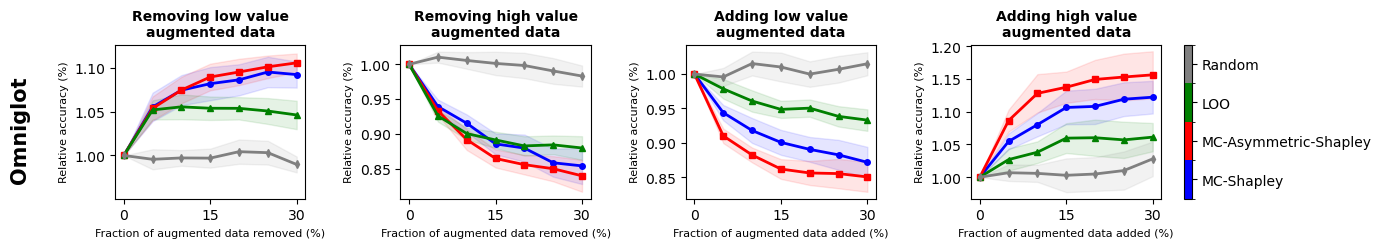

In [30]:
# Plot final plot: validation data
import matplotlib.pyplot as plt

modelname = 'logistic'

final_plot_avg(remove_high_avg, remove_low_avg, add_high_avg, 
               add_low_avg, shap_vals_algo_plot_lst,
               xticks=[0, 15, 30], remove_add_ratio = 30,
               root_dir='experiments/omniglot/final plot/validation data/',
               modelname='logistic', dataset='Omniglot', imbalance=False)